In [1]:
# import the required packages
from pyesgf.search import SearchConnection
import os
import glob
import requests
from tqdm import tqdm
import ec3

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from xclim import ensembles

# use this to suppress a warning which we can ignore
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "on"

/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xclim/indices/fire/_cffwis.py:218: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _day_length(lat: int | float, mth: int):  # pragma: no cover
/Users/mikemorris/opt/anaconda3/envs/UTCDW/lib/python3.9/site-packages/xclim/indices/fire/_cffwis.py:238: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detail

In [2]:
# establish a connection to the LLNL node
conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True)

# if that doesn't work, try the UK node
#conn = SearchConnection('https://esgf.ceda.ac.uk/esg-search', distrib=True)

# German Node:
#conn = SearchConnection('http://esgf-data.dkrz.de/esg-search', distrib=True)


In [3]:
query = conn.new_context(project="CMIP6",
                         experiment_id='historical,ssp585',
                         source_id = "CanESM5",
                         frequency = 'mon', # monthly ('day' for daily, '6hr' for 6-hourly, etc.)
                         member_id="r1i1p1f1",
                         variable_id = "tas")
results = query.search()

len(results)

19

In [4]:
# sometimes running this cell raises an error about shards, but running it a second time seems to work.
files = []
for i in range(len(results)):
    try:
        hit = results[i].file_context().search()
    except:
        hit = results[i].file_context().search()
    files += list(map(lambda f: {'filename': f.filename, 
                                 'download_url': f.download_url, 
                                 'opendap_url': f.opendap_url}, hit))
files = pd.DataFrame.from_dict(files)
len(files)

28

In [5]:
for fname in files['filename'].sort_values(): # print in alphabetical order
    print(fname)

tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc
tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc
tas_Amon_CanES

In [6]:
# filter the DataFrame to drop duplicate filenames
files = files.drop_duplicates('filename')
files

,filename,download_url,opendap_url
0,tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210...,http://crd-esgf-drc.ec.gc.ca/thredds/fileServe...,http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg...
1,tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218...,http://crd-esgf-drc.ec.gc.ca/thredds/fileServe...,http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg...
2,tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230...,http://crd-esgf-drc.ec.gc.ca/thredds/fileServe...,http://crd-esgf-drc.ec.gc.ca/thredds/dodsC/esg...
3,tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [7]:
# Adapted from: https://stackoverflow.com/a/37573701
def download(url, filename):
    """
    Download a file hosted at <url> and write to <filename>
    """
    print("Downloading ", filename)
    r = requests.get(url, stream=True)
    total_size, block_size = int(r.headers.get('content-length', 0)), 1024
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size),
                         total=total_size//block_size,
                         unit='KiB', unit_scale=True):
            f.write(data)

    if total_size != 0 and os.path.getsize(filename) != total_size:
        print("Downloaded size does not match expected size!\n",
              "FYI, the status code was ", r.status_code)

In [8]:
# create a directory (inside the current working directory) to save the data to
data_directory = "CanESM5_tas_monthly"
if not os.path.exists(data_directory): # only make the directory if it doesn't already exist
    os.mkdir(data_directory)



In [9]:
# download the data, one file at a time
for i in range(len(files)):
    url = files['download_url'].loc[i]
    filename = files['filename'].loc[i]
    path_to_write = os.path.join(data_directory, filename)
    
    # only download if the files doesn't already exist. 
    if not os.path.exists(path_to_write): 
        download(url, path_to_write)
    
    # if there is an error downloading a file, you'll need to either delete the file,
    # or change this block of code to call download(url, path_to_write) without 
    # first checking if path_to_write exists,

In [10]:
# loop through each file, just like when we downloaded them
for i in range(len(files)):
    filename = files['filename'].loc[i]
    filepath = os.path.join(data_directory, filename)
    filestats = os.stat(filepath)
    size_in_MB = filestats.st_size / 1e6 # convert bytes to megabytes
    print(f"Size of {filename}: {size_in_MB} MB")

Size of tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_201501-210012.nc: 27.267498 MB
Size of tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_210101-218012.nc: 25.23234 MB
Size of tas_Amon_CanESM5_ssp585_r1i1p1f1_gn_218101-230012.nc: 37.722355 MB
Size of tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc: 52.443019 MB


In [11]:
# first open the CanESM5 data for ensemble member r1i1p1f1
ds_CanESM5 = xr.open_mfdataset(data_directory + "/tas_Amon_CanESM5_*_r1i1p1f1_gn_*.nc")

In [12]:
# now get obs data - this function is copied and modified from Section 3.1
stn_ids_toronto_city = [5051, 31688, 41863]
df_list = []
for i, stn_id in enumerate(stn_ids_toronto_city):
    df = ec3.get_data(stn_id, 
                      type = 3, # monthly mean data
                      progress = False)
    if i > 0: # ensure no duplicate times
        df = df[df['Date/Time'] < df_list[i-1]['Date/Time'].min()]
    df_list.append(df)

df_obs = pd.concat(df_list, axis = 0)


column_name_dict = {'Date/Time': 'time', 
                    'Mean Temp (°C)': 'tas',
                    'Latitude (y)': 'lat',
                    'Longitude (x)': 'lon',
                    'Station Name': 'Name'}
    
df_obs = df_obs.rename(columns = column_name_dict)
df_obs = df_obs[list(column_name_dict.values())]
df_obs['time'] = pd.to_datetime(df_obs['time'])
df_obs = df_obs.set_index("time")
    
# sort the data in proper chronological order
df_obs = df_obs.sort_index()

# select data only up to 2015, when the "historical" simulation ends
df_obs = df_obs[df_obs.index.year.isin(range(1850, 2015))]

print(df_obs.index.min(), df_obs.index.max())

1850-01-01 00:00:00 2006-12-01 00:00:00


In [13]:
# interpolate the CanESM5 model data to the station location
station_lat = df_obs['lat'][0]
station_lon = df_obs['lon'][0] + 360 # model data longitudes go from (0, 360) instead of (-180, 180)

tas_CanESM5 = ds_CanESM5.tas.interp(lat = station_lat, lon = station_lon) - 273.15

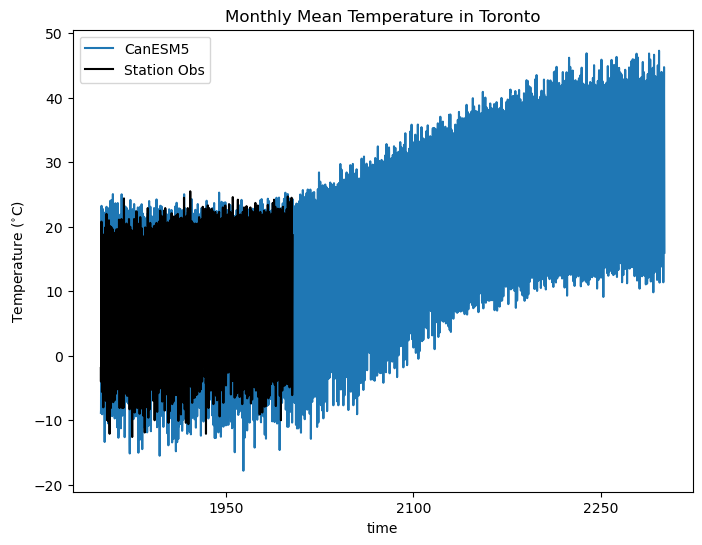

In [14]:
# station and model data have different time datatypes, so make a time axis with
# xarray to use for the obs
times_obs = xr.cftime_range(start = df_obs.index.min(), 
                            # need to add an extra month to the endpoint to make it closed at the right
                            end = df_obs.index.max() + pd.Timedelta(days=30), 
                            freq = 'M', calendar = 'noleap')
# plot the time series
fig, ax = plt.subplots(figsize = (8, 6))
tas_CanESM5.plot.line(ax = ax, label = 'CanESM5')
ax.plot(times_obs, df_obs['tas'], color = 'k', linestyle = '-', label = 'Station Obs')
ax.set_title("Monthly Mean Temperature in Toronto")
ax.set_ylabel(r"Temperature ($^{\circ}$C)")
plt.legend()
plt.show()

In [15]:
# select model data during obs period
obs_year_range = range(times_obs.year.min(), times_obs.year.max() + 1) # add one so the range includes the max year
tas_CanESM5_obsperiod = tas_CanESM5.sel(time = tas_CanESM5.time.dt.year.isin(obs_year_range))

# fit Kernel Density Estimator so we can plot a smooth distribution
kde_CanESM5 = stats.gaussian_kde(tas_CanESM5_obsperiod.values)
kde_obs = stats.gaussian_kde(df_obs['tas'].dropna().values) # need to drop missing values or else scipy complains


# mean values for each dataset
tas_CanESM5_mean = tas_CanESM5_obsperiod.mean('time')
tas_obs_mean = df_obs['tas'].mean()

# stdevs for each dataset
tas_CanESM5_stdev = tas_CanESM5_obsperiod.std('time')
tas_obs_stdev = df_obs['tas'].std()

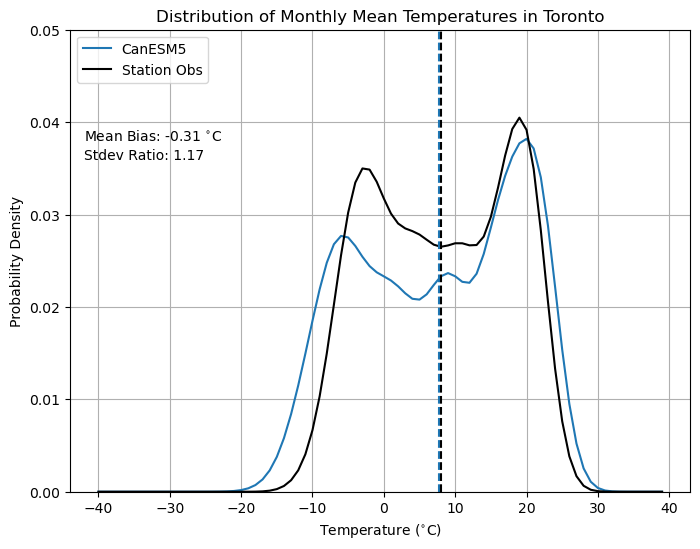

In [16]:
# range of temperatures to plot
temperatures = np.arange(-40, 40)
plt.figure(figsize = (8,6))
plt.title("Distribution of Monthly Mean Temperatures in Toronto")
plt.plot(temperatures, kde_CanESM5(temperatures), label = 'CanESM5')
plt.plot(temperatures, kde_obs(temperatures), label = 'Station Obs', color = 'k')
plt.vlines([tas_CanESM5_mean, tas_obs_mean], 0, 1, colors = ['tab:blue', 'k'], linestyles = '--')
plt.ylim(0, 0.05)
plt.xlabel(r"Temperature ($^{\circ}$C)")
plt.ylabel("Probability Density")
plt.legend(loc = 'upper left')
plt.grid()

# annotate with mean bias and ratio of stdevs
plt.text(-42, 0.038, r'Mean Bias: %.2f $^{\circ}$C' % (tas_CanESM5_mean - tas_obs_mean))
plt.text(-42, 0.036, r'Stdev Ratio: %.2f' % (tas_CanESM5_stdev / tas_obs_stdev))

plt.show()

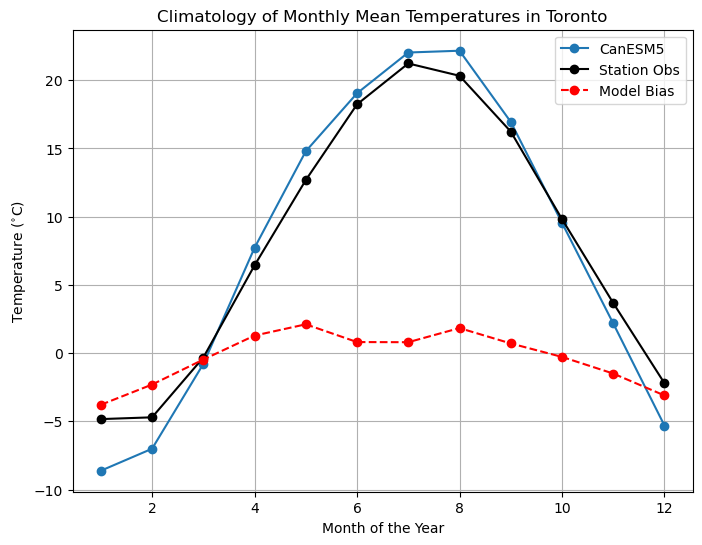

In [17]:
# calculate monthly climatologies
tas_monthlyclim_CanESM5 = tas_CanESM5_obsperiod.groupby('time.month').mean('time')
tas_monthlyclim_obs = df_obs['tas'].groupby(df_obs.index.month).mean()

# difference in climatologies
monthlyclim_bias = tas_monthlyclim_CanESM5.values - tas_monthlyclim_obs.values

months = tas_monthlyclim_CanESM5.month.values 

# plot
plt.figure(figsize = (8,6))
plt.title("Climatology of Monthly Mean Temperatures in Toronto")
plt.plot(months, tas_monthlyclim_CanESM5, label = 'CanESM5', marker = 'o')
plt.plot(months, tas_monthlyclim_obs, label = 'Station Obs', color = 'k', marker = 'o')
plt.plot(months, monthlyclim_bias, label = 'Model Bias', color = 'red', linestyle = '--', marker = 'o')
plt.xlabel("Month of the Year")
plt.ylabel(r"Temperature ($^{\circ}$C)")
plt.legend()
plt.grid()
plt.show()

In [18]:
# select historical and future periods
tas_CanESM5_hist = tas_CanESM5.sel(time = tas_CanESM5.time.dt.year.isin(range(1971, 2001)))
tas_CanESM5_future = tas_CanESM5.sel(time = tas_CanESM5.time.dt.year.isin(range(2071, 2101)))


In [19]:
# calculate effective sample size for historical and future periods
def effective_sample_size(data):
    ntime = len(data.time)
    # times not including the final timestep
    times = data.time.isel(time = slice(0, ntime - 1))
    # data not including the first timestep
    data_lag = data.isel(time = slice(1, ntime))
    # match up time values, otherwise the xr.corr function won't return the correct output
    data_lag = data_lag.assign_coords(time = times)
    
    # calculate correlation
    autocor = xr.corr(data.sel(time = times),
                      data_lag,
                      dim = 'time')
    
    neff = ntime * (1 - autocor) / (1 + autocor)
    
    return neff

neff_hist = effective_sample_size(tas_CanESM5_hist)
neff_future = effective_sample_size(tas_CanESM5_future)

In [20]:
# calculate means and stdevs for each period
tas_CanESM5_hist_mean = tas_CanESM5_hist.mean('time')
tas_CanESM5_future_mean = tas_CanESM5_future.mean('time')

tas_CanESM5_hist_std = tas_CanESM5_hist.std('time')
tas_CanESM5_future_std = tas_CanESM5_future.std('time')

# perform two_sample t-test to see if future temperatures are higher than past
tstat, pval_neff = stats.ttest_ind_from_stats(tas_CanESM5_hist_mean,
                                              tas_CanESM5_hist_std,
                                              neff_hist,
                                              tas_CanESM5_future_mean, 
                                              tas_CanESM5_future_std, 
                                              neff_future,
                                              equal_var = False,
                                              alternative = 'less') 
# alt hypothesis is that the first dataset (historical) has a lower mean than the second dataset (future)

# do it again using the total sample size, to demonstrate how the p-value will be underestimated
tstat, pval_ntot = stats.ttest_ind_from_stats(tas_CanESM5_hist_mean,
                                              tas_CanESM5_hist_std,
                                              len(tas_CanESM5_hist.time),
                                              tas_CanESM5_future_mean, 
                                              tas_CanESM5_future_std, 
                                              len(tas_CanESM5_future.time),
                                              equal_var = False,
                                              alternative = 'less')

# print each p-value to 6 significant figures
print("Total Sample Size p-value: %.6f" % pval_ntot)
print("Effective Sample Size p-value: %.6f" % pval_neff)

Total Sample Size p-value: 0.000000


Effective Sample Size p-value: 0.001478


In [21]:
def mann_kendall_pvalue(data):
    N = len(data.time)
    # kendall tau  - the np.arange(N) is there to represent the monotonically increasing time axis
    tau = stats.kendalltau(data, np.arange(N))[0]
    
    # use tau to calculate the S statistic
    S = tau * N * (N-1) / 2

    # calculate the variance and effective variance,
    # taking advantage of our effective_sample_size function from the last example
    var_S = N * (N - 1) * (2*N + 5) / 18
    N_eff = effective_sample_size(data)
    correction_factor = N / N_eff
    var_S_eff = var_S * correction_factor
    
    # standarize S to a z-score
    z = (S - np.sign(S)) / np.sqrt(var_S_eff)
    
    # calculate one-sided p-value using the standard normal distribution
    pval = stats.norm.sf(z)
    
    return pval
    


In [22]:
pval_trend_mk = mann_kendall_pvalue(tas_CanESM5.sel(time = tas_CanESM5.time.dt.year <= 2100))
print("Mann-Kendall Test p-value for Trend: %.6f" % pval_trend_mk)

Mann-Kendall Test p-value for Trend: 0.000083


In [23]:
query2 = conn.new_context(project="CMIP6",
                         experiment_id='historical',
                         source_id = "CanESM5",
                         frequency = 'mon',
                         member_id="r2i1p1f1,r3i1p1f1,r4i1p1f1",
                         variable_id = "tas")
results2 = query2.search()
files2 = []
for i in range(len(results2)):
    try:
        hit = results2[i].file_context().search()
    except:
        hit = results2[i].file_context().search()
    files2 += list(map(lambda f: {'filename': f.filename, 
                                 'download_url': f.download_url, 
                                 'opendap_url': f.opendap_url}, hit))
files2 = pd.DataFrame.from_dict(files2)
files2 = files2.drop_duplicates('filename')

files2

,filename,download_url,opendap_url
0,tas_Amon_CanESM5_historical_r4i1p1f1_gn_185001...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...
1,tas_Amon_CanESM5_historical_r3i1p1f1_gn_185001...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...
2,tas_Amon_CanESM5_historical_r2i1p1f1_gn_185001...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...


In [24]:
# download the file
for i in range(len(files2)):
    url = files2['download_url'].loc[i]
    filename = files2['filename'].loc[i]
    path_to_write = os.path.join(data_directory, filename)
    
    # only download if the files doesn't already exist. 
    if not os.path.exists(path_to_write): 
        download(url, path_to_write)

In [25]:
# create a list of the files to create the ensemble, using the wildcard character
historical_files = glob.glob(data_directory + "/tas_Amon_CanESM5_historical_*_gn_185001-201412.nc")

# open up the two historical files using xclim.ensembles
ds_ensemble = ensembles.create_ensemble(historical_files)

# print a summary of the dataset - the dimension 'realization' represents the ensemble member
ds_ensemble

<xarray.Dataset>
Dimensions:      (time: 1980, realization: 4, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height       float64 2.0
  * realization  (realization) int64 0 1 2 3
Dimensions without coordinates: bnds
Data variables:
    time_bnds    (realization, time, bnds) float64 dask.array<chunksize=(1, 1980, 2), meta=np.ndarray>
    lat_bnds     (realization, lat, bnds) float64 dask.array<chunksize=(1, 64, 2), meta=np.ndarray>
    lon_bnds     (realization, lon, bnds) float64 dask.array<chunksize=(1, 128, 2), meta=np.ndarray>
    tas          (realization, time, lat, lon) float32 dask.array<chunksize=(1, 1980, 64, 128), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/872062df-acae-499b-aa0f-9eaca76...
    variable_id:                 tas
    variant_label:               r1i1p1f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.4.0

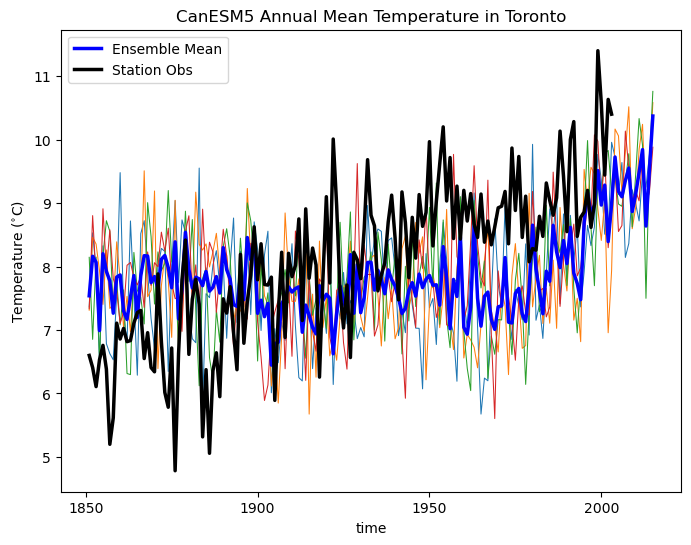

In [26]:
# interpolate the data to the Toronto station location
tas_CanESM5_ensemble = ds_ensemble.tas.interp(lat = station_lat, lon = station_lon) - 273.15

# calculate annual means - plotting monthly means is too nosiy to see the example clearly
tas_CanESM5_ensemble_annual = tas_CanESM5_ensemble.resample(time = 'Y').mean()
tas_obs_annual = df_obs['tas'].resample('Y').mean()

# obs data is missing for a few years, and incomplete for 2003
tas_obs_annual = tas_obs_annual[tas_obs_annual.index.year < 2003]

# obs data year values to pass to plotting function
yrmax_obs = tas_obs_annual.index.year.max()
yrs_obs = tas_CanESM5_ensemble_annual.time.sel(time = tas_CanESM5_ensemble_annual.time.dt.year <= yrmax_obs)

# calculate ensemble mean to include in the plot
tas_CanESM5_annual_ensmean = tas_CanESM5_ensemble_annual.mean("realization")

# plot a time series of the annual mean temperatures for Toronto, using a different colour for each ensemble member
fig, ax = plt.subplots(figsize = (8, 6))
# ensemble mean
tas_CanESM5_annual_ensmean.plot.line(ax = ax, color = 'blue', 
                                     label = 'Ensemble Mean', 
                                     linewidth = 2.5, zorder = 2)

ax.plot(yrs_obs, tas_obs_annual, color = 'k', 
        label = 'Station Obs', linewidth = 2.5, zorder = 2)

tas_CanESM5_ensemble_annual.plot.line(ax = ax, hue = 'realization', 
                                      linewidth = 0.75,
                                      add_legend = False, 
                                      zorder = 1)

ax.set_title("CanESM5 Annual Mean Temperature in Toronto")
ax.set_ylabel(r"Temperature ($^{\circ}$C)")
ax.legend()
plt.show()
